# Continuous Control


### 1. Start the Environment

In [1]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
import torch
from agents.ddpg.ddpg_agent import DDPG_Agent
from agents.ddpg import parameters
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
torch.cuda.is_available()

using device: cuda


True

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
# This line should lunch the compiled unity project created with  ml-agents in unity 
env = UnityEnvironment(file_name='./Reacher_Linux/20_agents/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [2]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

## DDPG agent

In [5]:
# Instantiating DDPG agent
random_seed = 0
ddpg_agent = DDPG_Agent(state_size, action_size, random_seed)

In [6]:
## Parameters
EPISODES = 250 # Number of episodes to train
PRINT_EVERY = 100 # Print every "x" episodes
RECORD_EVERY = 25 # Saved the weights every "x" episodes

In [24]:
# Training DDPG agent
cumulative_score = deque(maxlen=PRINT_EVERY)
score_history = []
actor_lr_history = []
critic_lr_history = []
for episode in range(1, EPISODES+1):
    ddpg_agent.reset()                                                  # reset OUNoise from ddpg agent
    env_info = env.reset(train_mode=True)[brain_name]                   # reset the environment    
    states = env_info.vector_observations                               # get the current state (for each agent)
    scores = np.zeros(num_agents)                                       # initialize the score (for each agent)
    all_agents_score = 0
    steps = 0
    while True:
        actions = ddpg_agent.act(states)                                # select an action (for each agent)
        env_info = env.step(actions)[brain_name]                        # send all actions to tne environment
        next_states = env_info.vector_observations                      # get next state (for each agent)
        rewards = env_info.rewards                                      # get reward (for each agent)
        dones = env_info.local_done                                     # see if episode finished

        ddpg_agent.step(states, actions, rewards, next_states, dones)   # Save experience in replay memory, and use random sample from buffer to learn.
        scores += rewards                                               # update the score (for each agent)
        states = next_states                                            # roll over states to next time step
        steps += 1
        if np.any(dones):
            break
    all_agents_score = np.mean(scores)
    score_history.append(all_agents_score)
    cumulative_score.append(all_agents_score)

    ## Modifying learning rate
    actor_lr = ddpg_agent.actor_optimizer.param_groups[0]['lr']
    critic_lr = ddpg_agent.critic_optimizer.param_groups[0]['lr']
    actor_lr_history.append(actor_lr)
    critic_lr_history.append(critic_lr)
    if 20 < episode < 70:     
        ddpg_agent.actor_optimizer.param_groups[0]['lr'] = ((parameters.LR_ACTOR/10-parameters.LR_ACTOR)/100)*episode+parameters.LR_ACTOR
        ddpg_agent.critic_optimizer.param_groups[0]['lr'] = ((parameters.LR_CRITIC/10-parameters.LR_CRITIC)/100)*episode+parameters.LR_CRITIC
    elif 70 < episode < 201:
        ddpg_agent.actor_optimizer.param_groups[0]['lr'] = -9e-7*episode+1.9e-4
        ddpg_agent.critic_optimizer.param_groups[0]['lr'] = -9e-7*episode+1.9e-4
    
    print(f'Episode: {episode}, all agents mean score: {all_agents_score}, actor_LR = {actor_lr}, critic_LR = {critic_lr}', end="\r")
    if episode%PRINT_EVERY == 0:
        print(f'\n#### Episode: {episode}, cumulative_score: {np.mean(cumulative_score)} ####\n', end="\r")
    if episode%RECORD_EVERY == 0:
        torch.save(ddpg_agent.actor_local.state_dict(), f'checkpoint_actor_{episode}.pth')
        torch.save(ddpg_agent.critic_local.state_dict(), f'checkpoint_critic_{episode}.pth')
        




Episode: 200, all agents mean score: 28.717499358113855, actor_LR = 1.0900000000000021e-05, critic_LR = 1.0900000000000021e-05
#### Episode: 200, cumulative_score: 31.20724320490277 ####


In [25]:
env.close()

using device: cuda


In [26]:
# Final comulative avg score of all agents in the last 100 epochs
print(f'\n#### Episode: {episode}, cumulative_score: {np.mean(cumulative_score)} ####\n')


#### Episode: 250, cumulative_score: 30.555241075278886 ####



In [30]:
np.loadtxt('score_history.csv', delimiter=',')[80]

23.97249946417287

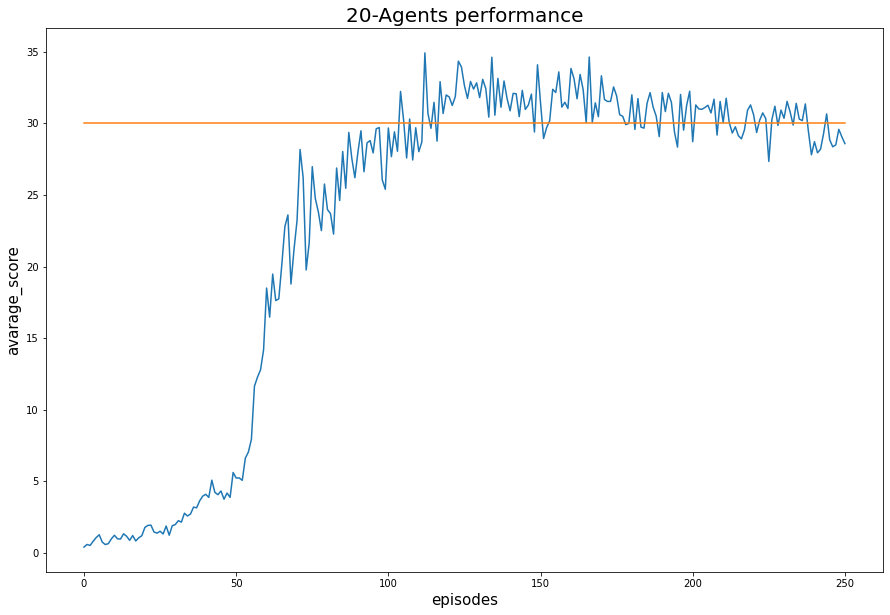

In [55]:
plt.figure(figsize=(15,10))
plt.plot(score_history)
plt.plot([30]*len(score_history))
plt.xlabel('episodes', fontsize = 15)
plt.ylabel('avarage_score', fontsize = 15)
plt.title('20-Agents performance', fontsize = 20)
plt.show()

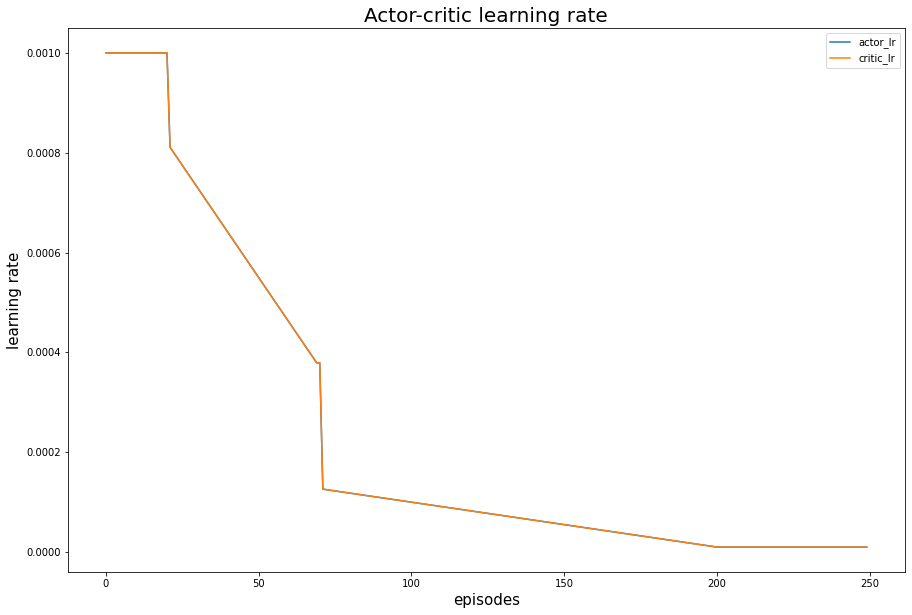

In [59]:
plt.figure(figsize=(15,10))
plt.plot(actor_lr_history)
plt.plot(critic_lr_history)
plt.legend(['actor_lr', 'critic_lr'])
plt.xlabel('episodes', fontsize = 15)
plt.ylabel('learning rate', fontsize = 15)
plt.title('Actor-critic learning rate', fontsize = 20)
plt.show()

# Loading models at different stages of training
In this section we will load different checkpoints to see how the model behaves at different episodes for illustration purposes

In [24]:
# Instantiating DDPG agent
random_seed = 0
EPISODE_TRAINED = 50
ddpg_agent_inference = DDPG_Agent(state_size, action_size, random_seed)
ddpg_agent_inference.actor_local.load_state_dict(torch.load(f'checkpoint_actor_{EPISODE_TRAINED}.pth'))
ddpg_agent_inference.critic_local.load_state_dict(torch.load(f'checkpoint_critic_{EPISODE_TRAINED}.pth'))

<All keys matched successfully>

In [25]:
# Inference
score_history = []
ddpg_agent_inference.reset()                                                  # reset OUNoise from ddpg agent
env_info = env.reset(train_mode=False)[brain_name]                   # reset the environment    
states = env_info.vector_observations                               # get the current state (for each agent)
scores = np.zeros(num_agents)                                       # initialize the score (for each agent)
all_agents_score = 0

while True:
    actions = ddpg_agent_inference.act(states)                      # select an action (for each agent)
    env_info = env.step(actions)[brain_name]                        # send all actions to tne environment
    next_states = env_info.vector_observations                      # get next state (for each agent)
    rewards = env_info.rewards                                      # get reward (for each agent)
    dones = env_info.local_done                                     # see if episode finished
    scores += rewards                                               # update the score (for each agent)
    states = next_states                                            # roll over states to next time step
    if np.any(dones):
        break
print(f'All agents mean score: {np.mean(scores)}')

All agents mean score: 2.415499946009368
